<p style="text-align: center;">
<font size="5">
A Simulation of the Adiabatic Oracle Described in "Bin Yan, & Nikolai A. Sinitsyn. (2023). An adiabatic oracle for Grover's algorithm."
<br>
<br>
By Ben Freiman
<br>
<p style="text-align: left;">
<font size="3">
This is still a work in progress


In [4]:
import numpy as np
import qiskit
from qiskit import *
import matplotlib as mpl

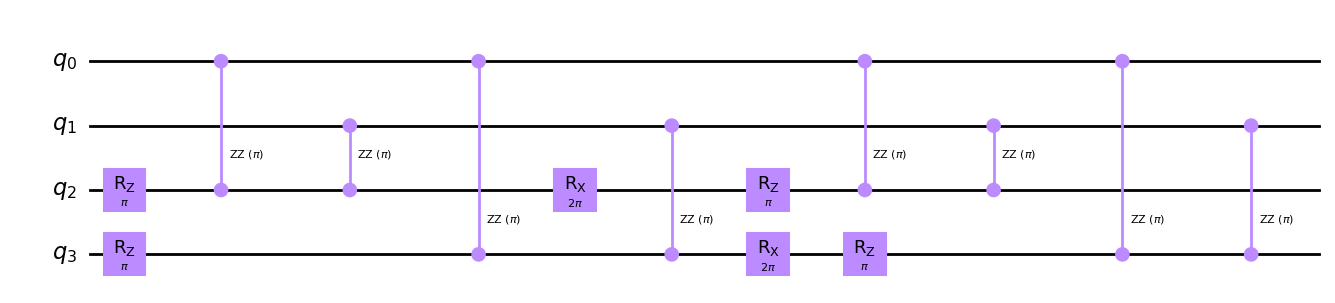

In [5]:
def ising_generator(A,dt,num_qbits) -> qiskit.circuit.Gate:
    ising = QuantumCircuit(num_qbits,name='A')
    for j in range(num_qbits-2,num_qbits,1):
        ising.rz(A*np.pi*dt,j)
        for i in range(num_qbits-2):
            ising.rzz(A*np.pi*dt,i,j)
    ising.to_gate()
    return ising

def sigma_x(B,dt) -> qiskit.circuit.Gate:
    sig_x = QuantumCircuit(1,name='B')
    sig_x.rx(B*np.pi*2*dt,0)
    sig_x.to_gate()
    return sig_x

def evolution_generator(A,B,dt,num_qbits) -> qiskit.circuit.Gate:
    evoloution_operator = QuantumCircuit(num_qbits,name='ABA')
    
    evoloution_operator.append(ising_generator(A,dt,num_qbits),range(num_qbits))
    
     #Term attached to B(t)
    evoloution_operator.append(sigma_x(B,dt),[num_qbits-2])
    evoloution_operator.append(sigma_x(B,dt),[num_qbits-1])
    
    #Term attached to A(t)
    evoloution_operator.append(ising_generator(A,dt,num_qbits),range(num_qbits))
    return evoloution_operator
def grovers_circuit_initializatoin(num_qbits,lower_energy_states) -> qiskit.circuit:
    backend = Aer.get_backend('statevector_simulator')
    circ = QuantumCircuit(num_qbits,num_qbits)

    #Prepare the lower_energy_states in a superposition |0> + |1>
    initial_state = [1,0]
    for i in lower_energy_states:
        circ.initialize(initial_state, i)
        circ.h(i)
    #Project ancillary qbits to the x+- states
    circ.h(num_qbits-2) #Hadamard Gate
    #0->1 state for 3rd qbit
    initial_state = [0,1]
    circ.initialize(initial_state, num_qbits-1)
    circ.h(num_qbits-1) #Hadamard Gate
    return circ

def grovers_circuit_execution(circ,lower_energy_states) -> qiskit.circuit:
    T = 150 #Total Time
    n = 2000 #Iterations
    dt = T/n
    for t in range(n+1):
        A = 1-t/T
        B = t/T

        #Term attached to A(t)
        evo_op = evolution_generator(A,B,dt,num_qbits)
        if (t ==10):
            evo_op.decompose().draw('mpl')
        circ.append(evo_op,range(num_qbits))

        if (t == 2000):
            break
    #Project to the z01 states
    circ.h(lower_energy_states)
    circ.h(num_qbits-2) #Hadamard Gate
    circ.h(num_qbits-1) #Hadamard Gate
    return circ

#This variation can directly be used in grovers algorithm
def grovers_circuit_execution_no_h_gate(circ,lower_energy_states) -> qiskit.circuit:
    T = 150 #Total Time
    n = 2000 #Iterations
    dt = T/n
    for t in range(n+1):
        A = 1-t/T
        B = t/T

        #Term attached to A(t)
        evo_op = evolution_generator(A,B,dt,num_qbits)
        if (t ==10):
            evo_op.decompose().draw('mpl')
        circ.append(evo_op,range(num_qbits))

        if (t == 2000):
            break
    #Project to the z01 states
    circ.h(num_qbits-2) #Hadamard Gate
    circ.h(num_qbits-1) #Hadamard Gate
    return circ

evo_op = evolution_generator(1,1,1,4)
evo_op.decompose().draw('mpl')

## Demonstration of Phase Oracle

In [16]:
#This is the quanutm circuit with two bits of information
num_qbits = 8
lower_energy_states = [1,4]

grovers_circ = grovers_circuit_initializatoin(num_qbits,lower_energy_states)

grovers_circ = grovers_circuit_execution(grovers_circ,lower_energy_states)

backend = Aer.get_backend('statevector_simulator')
circ = grovers_circ.reverse_bits() #Key to reading the bits from q0->q3 rather than q3->q0
circ.measure(range(num_qbits),range(num_qbits))
shots = 1000
job=execute(circ,backend,shots=1000)
result=job.result()
result = result.get_counts()
count=0
for bit_string in result:
    if(bit_string[num_qbits-2:num_qbits] == '00' or bit_string[num_qbits-2:num_qbits] == '11'):
        count += result[bit_string]
print("The percentage of sucessful oracle calls should be ~1/2, this simulation was sucessful on the order of", count/shots, "of the oracle queries.")

The percentage of sucessful oracle calls should be ~1/2, this simulation was sucessful on the order of 0.428 of the oracle queries.


## Phase Oracle Confirmation with Ancillary Qbits

In [7]:
#This is the quanutm circuit with two bits of information
num_qbits = 8
lower_energy_states = [1,4]

grovers_circ = grovers_circuit_initializatoin(num_qbits,lower_energy_states)

grovers_circ = grovers_circuit_execution(grovers_circ,lower_energy_states)

backend = Aer.get_backend('statevector_simulator')
circ = grovers_circ.reverse_bits() #Key to reading the bits from q0->q3 rather than q3->q0
circ.measure(range(num_qbits),range(num_qbits))
shots = 1000
job=execute(circ,backend,shots=shots)
result=job.result()
result = result.get_counts()
print(result)
count = 0
for bit_string in result:
    if(bit_string[num_qbits-2:num_qbits] == '00' or bit_string[num_qbits-2:num_qbits] == '11'):
        count += result[bit_string]
print("The percentage of sucessful oracle calls should be ~1/2, this simulation was sucessful on the order of", count/shots, "of the oracle queries.")

{'00000010': 433, '01001011': 187, '01001000': 214, '00001010': 6, '00000001': 129, '01001001': 8, '01000001': 6, '01000011': 1, '00001001': 5, '01000010': 5, '01001010': 5, '01000000': 1}
The percentage of sucessful oracle calls should be ~1/2, this simulation was sucessful on the order of 0.403 of the oracle queries.


## Grovers Algorithm Without Amplification

In [10]:
#This is the quanutm circuit with two bits of information
pi = np.pi
num_qbits = 6 #4 qbits
lower_energy_states = [1]

grovers_circ = grovers_circuit_initializatoin(num_qbits,lower_energy_states)

grovers_circ = grovers_circuit_execution_no_h_gate(grovers_circ,lower_energy_states)

temp_circ = grovers_circ
temp_circ.h(lower_energy_states)
backend = Aer.get_backend('statevector_simulator')
circ = temp_circ.reverse_bits() #Key to reading the bits from q0->q3 rather than q3->q0
circ.measure(range(num_qbits),range(num_qbits))
shots = 10000
job=execute(circ,backend,shots=shots)
result=job.result()
result = result.get_counts()
print(result)
count = 0
for bit_string in result:
    if(bit_string == '010011' or bit_string == '010000'):
        count += result[bit_string]
print("The percentage of sucessful oracle calls should be ~1/2, this simulation was sucessful on the order of", count/shots, "of the oracle queries.")

{'010011': 2248, '000010': 3456, '000001': 1702, '010000': 2237, '000000': 3, '010001': 173, '000011': 5, '010010': 176}
The percentage of sucessful oracle calls should be ~1/2, this simulation was sucessful on the order of 0.4485 of the oracle queries.


<p style="text-align: left;">
<font size="2">
Here, we take the final state from above without the haddamard gate applied to the lowered energy states list (qbit 1). We then apply amplitude amplification. The oracle works less than %50 of the time and the second qbit is in a superposiion namely $q1 = \frac{1}{\sqrt{2}}(|0\rangle-|1\rangle)$. The probability of haveing a sucessful oracle query and measuing the qbit in the $|1\rangle$ state has an upper bound at $\frac{1}{4}.$ Here we apply amplitude amplification to see if we can push that upper bound. If we find a probability greator than 1/4, grovers algorithm is sucessful.
<br>
<br>
The code below might need to be run multiple times to see meaningful results.


In [13]:
#######################
#### Amplification ####
#######################
grovers_circ.h(0)
grovers_circ.h(1)
grovers_circ.h(2)
grovers_circ.h(3)
grovers_circ.x(0)
grovers_circ.x(1)
grovers_circ.x(2)
grovers_circ.x(3)
######## cccZ #########
grovers_circ.cp(pi/4, 0, 3)
grovers_circ.cx(0, 1)
grovers_circ.cp(-pi/4, 1, 3)
grovers_circ.cx(0, 1)
grovers_circ.cp(pi/4, 1, 3)
grovers_circ.cx(1, 2)
grovers_circ.cp(-pi/4, 2, 3)
grovers_circ.cx(0, 2)
grovers_circ.cp(pi/4, 2, 3)
grovers_circ.cx(1, 2)
#APPENDIX A. QISKIT CODE 33
grovers_circ.cp(-pi/4, 2, 3)
grovers_circ.cx(0, 2)
grovers_circ.cp(pi/4, 2, 3)
####### end cccZ #######
grovers_circ.x(0)
grovers_circ.x(0)
grovers_circ.x(2)
grovers_circ.x(3)
grovers_circ.h(0)
grovers_circ.h(1)
grovers_circ.h(2)
grovers_circ.h(3)

backend = Aer.get_backend('statevector_simulator')
circ = grovers_circ.reverse_bits() #Key to reading the bits from q0->q3 rather than q3->q0
circ.measure(range(num_qbits),range(num_qbits))
job=execute(circ,backend,shots=10000)
result=job.result()
result = result.get_counts()
print(result)
count = 0
for bit_string in result:
    if(bit_string == '010011' or bit_string == '010000'):
        count += result[bit_string]
print("The percentage of Grovers Algorithm Calls should be ~1/4, this simulation was sucessful on the order of", count/shots, "of the oracle queries.")

{'011111': 44, '010011': 1713, '101011': 34, '110101': 45, '000010': 2795, '110110': 28, '101010': 35, '000001': 1189, '010000': 1729, '001000': 42, '100110': 36, '111010': 27, '001111': 37, '001101': 37, '111100': 40, '100100': 45, '011101': 44, '001011': 32, '111110': 31, '100010': 34, '011000': 43, '101000': 31, '100111': 43, '010001': 35, '010010': 358, '011011': 40, '110011': 32, '000100': 34, '101101': 49, '001100': 33, '111101': 46, '100011': 47, '010101': 53, '000101': 44, '101110': 31, '110010': 29, '101001': 55, '111111': 34, '100001': 37, '001010': 35, '111000': 29, '011001': 36, '110100': 34, '000011': 19, '101100': 40, '101111': 38, '000110': 30, '110001': 59, '100000': 42, '111001': 46, '011110': 26, '110111': 35, '000000': 17, '001001': 52, '000111': 45, '110000': 38, '010111': 30, '100101': 35, '001110': 26, '111011': 38, '010110': 38, '011100': 40, '010100': 46, '011010': 35}
The percentage of Grovers Algorithm Calls should be ~1/4, this simulation was sucessful on the

## Note: Using a quanutm computer where the last two qbits can be measured, the oracle can be called over and over would result in a higher probability. Aditionally, applying amplitude amplification over and over would have a positive effect on the result.

## Aditional References:<br>
Karlsson, V.B., & Strömberg, P. (2018). 4-qubit Grover's algorithm implemented for the ibmqx5 architecture.